# Overview

In this notebook, we form stack trace pairs from a set stack traces, for each stack pairs we compute the similarity value regarding the used similarity measure.  
In this notebook we study the following similarity measures:  
01. Jaccard  
02. Cosine  
03. TF-IDF  
04. Edit distance or Levenshtein distance    
05. PDM   
06. Brodie  
07. Durfex  
08. Lerch  
09. Moroo  
10. TraceSIM  

In [22]:
import os
import sys
import numpy as np
import pandas as pd
from gensim.models import FastText
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import scipy.stats as stats 

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),'python-packages/'))
from similarities import *

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data/')
fastText_repo = os.path.join(os.getcwd(),'fastText-models/')

In [4]:
data_repo

'/home/yre/notebooks-ia/stack-traces-sim/DeepLSH/data/'

In [5]:
df = pd.read_csv(data_repo + 'stack_traces.csv', index_col = [0])

In [6]:
df.head()

,timestamp,typeStackTrace,stackTrace,stackTraceCusto
0,2021-11-19 17:20:39.934,java.lang.Throwable,class java.lang.Throwable : __trad__AABHQ29udH...,com.myCompany.gpao.client.modules.atelier.post...
1,2021-11-22 06:11:55.332,java.lang.Throwable,class java.lang.Throwable : __trad__AABUQ29udH...,com.myCompany.gpao.client.modules.atelier.post...
2,2021-11-22 06:20:23.783,java.lang.Throwable,class java.lang.Throwable : __trad__AABHQ29udH...,com.myCompany.gpao.client.modules.atelier.post...
3,2021-11-23 06:59:12.738,org.eclipse.swt.SWTException,class org.eclipse.swt.SWTException : Widget is...,org.eclipse.swt.SWT.error\norg.eclipse.swt.SWT...
4,2021-11-22 06:26:52.890,java.lang.Throwable,class java.lang.Throwable : __trad__AABnQ29udH...,com.myCompany.gpao.client.modules.atelier.post...


In [7]:
n_stack_traces = 1000
df_distinct_stacks = pd.DataFrame()
df_distinct_stacks['stackTraceCusto'] = df['stackTraceCusto'].value_counts().index[:n_stack_traces]
df_distinct_stacks['stackTraceCusto'] = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\r',''))
df_distinct_stacks['stackTraceCusto'] = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\na','\n'))
df_distinct_stacks.to_csv(data_repo + 'frequent_stack_traces.csv')

In [8]:
df['listStackTrace'] = df['stackTraceCusto'].apply(lambda x : x.replace('\n', ' ').strip().split(' '))
df_distinct_stacks['listStackTrace'] = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n', ' ').strip().split(' '))

In [9]:
df_measures = pd.DataFrame()

# 1. Jaccard

In [10]:
%%time
sim_jaccard = df_distinct_stacks.apply(lambda x : jaccard_df(x['listStackTrace'], df_distinct_stacks['listStackTrace'], rowIndex(x)), axis = 1)
df_measures['Jaccard'] = pd.Series([elt for l in sim_jaccard for elt in l])

CPU times: user 2.82 s, sys: 30.8 ms, total: 2.86 s
Wall time: 2.86 s


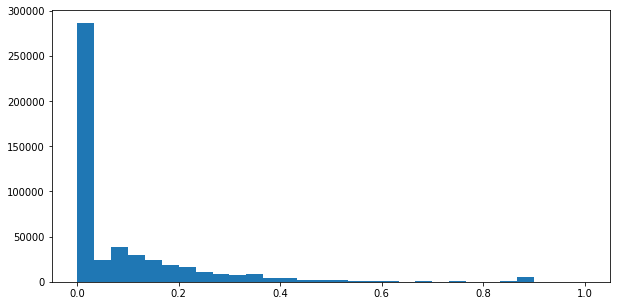

In [11]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['Jaccard'], 30, alpha = 1, density = False)
plt.show()

# 2. Cosine

In [12]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [13]:
%%time
sim_cosine = df_bag_of_frames.apply(lambda x : cosine_similarity_df(x, df_bag_of_frames, rowIndex(x)), axis = 1)
df_measures['Cosine'] = pd.Series([element for l in sim_cosine for element in l])

CPU times: user 59.8 s, sys: 34.4 ms, total: 59.8 s
Wall time: 1min


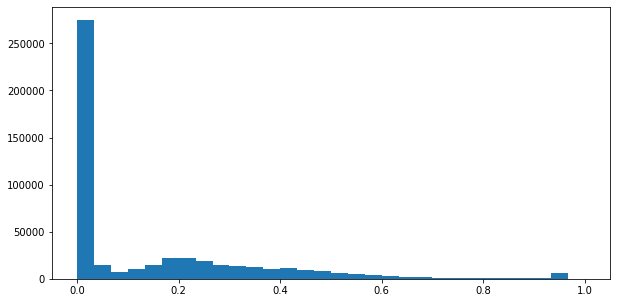

In [14]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['Cosine'], 30, alpha = 1, density = False)
plt.show()

# 3. TF-IDF

In [15]:
vectorizer_tf_idf = TfidfVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_tf_idf = vectorizer_tf_idf.fit_transform(list(s)).toarray()
df_tf_idf = pd.DataFrame(data = X_tf_idf, columns = vectorizer_tf_idf.get_feature_names())

In [16]:
%%time
sim_tfidf = df_tf_idf.apply(lambda x : cosine_similarity_df(x, df_tf_idf, rowIndex(x)), axis = 1)
df_measures['TfIdf'] = pd.Series([element for l in sim_tfidf for element in l])

CPU times: user 55.1 s, sys: 54.7 ms, total: 55.2 s
Wall time: 55.4 s


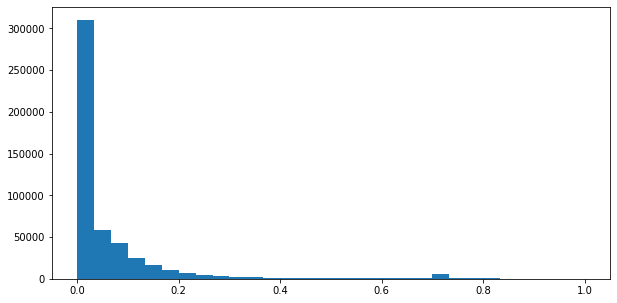

In [17]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['TfIdf'], 30, alpha = 1, density = False)
plt.show()

# 4. Levenshtein

In [18]:
%%time
sim_levensh = df_distinct_stacks.apply(lambda x : levenshtein_df(x['listStackTrace'], df_distinct_stacks['listStackTrace'], rowIndex(x)), axis = 1)
df_measures['Levensh'] = pd.Series([element for l in sim_levensh for element in l])

CPU times: user 59.3 s, sys: 19.8 ms, total: 59.3 s
Wall time: 59.5 s


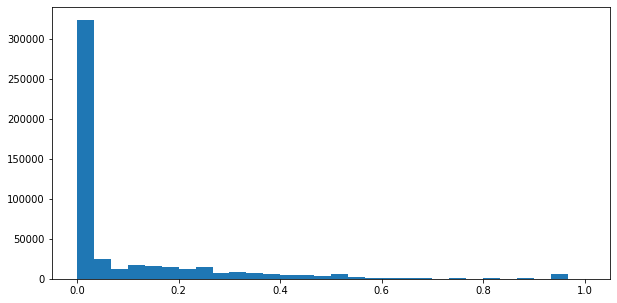

In [19]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['Levensh'], 30, alpha = 1, density = False)
plt.show()

# 5. PDM-Rebucket[[Paper](https://www.researchgate.net/publication/254041628_ReBucket_A_method_for_clustering_duplicate_crash_reports_based_on_call_stack_similarity)]

In [24]:
%%time
sim_pdm = df_distinct_stacks.apply(lambda x : pdm_df(x['listStackTrace'], df_distinct_stacks['listStackTrace'], rowIndex(x)), axis = 1)
df_measures['PDM'] = pd.Series([element for l in sim_pdm for element in l])

CPU times: user 2min 6s, sys: 24.9 ms, total: 2min 6s
Wall time: 2min 6s


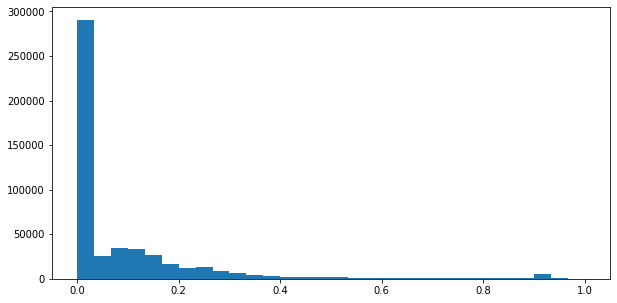

In [25]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['PDM'], 30, alpha = 1, density = False)
plt.show()

# 6. Brodie [[Paper](https://www.cs.drexel.edu/~spiros/teaching/CS576/papers/Brodie_ICAC05.pdf)]

In [26]:
%%time
sim_brodie = df_distinct_stacks.apply(lambda x : brodie_df(x['listStackTrace'], df_distinct_stacks['listStackTrace'], rowIndex(x), df_bag_of_frames), axis = 1)
df_measures['Brodie'] = pd.Series([element for l in sim_brodie for element in l])

CPU times: user 44min 43s, sys: 1.25 s, total: 44min 45s
Wall time: 44min 56s


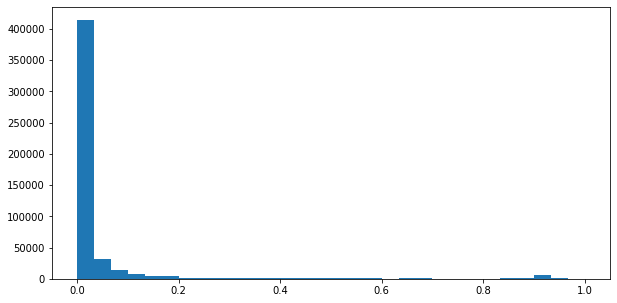

In [27]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['Brodie'], 30, alpha = 1, density = False)
plt.show()

# 7. Dufrex [[Paper](https://users.encs.concordia.ca/~abdelw/papers/QRS17-Durfex.pdf)]

In [28]:
vectorizer_dufrex = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b", ngram_range=(1, 3))
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : ' '.join([elt.rpartition('.')[0] for elt in x.split('\n')]))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_dufrex = vectorizer_dufrex.fit_transform(list(s)).toarray()
df_dufrex = pd.DataFrame(data = X_dufrex, columns = vectorizer_dufrex.get_feature_names())

In [29]:
%%time
sim_dufrex= df_dufrex.apply(lambda x : cosine_similarity_df(x, df_dufrex, rowIndex(x)), axis = 1)
df_measures['Dufrex'] = pd.Series([element for l in sim_dufrex for element in l])

CPU times: user 1min 12s, sys: 20.7 ms, total: 1min 12s
Wall time: 1min 12s


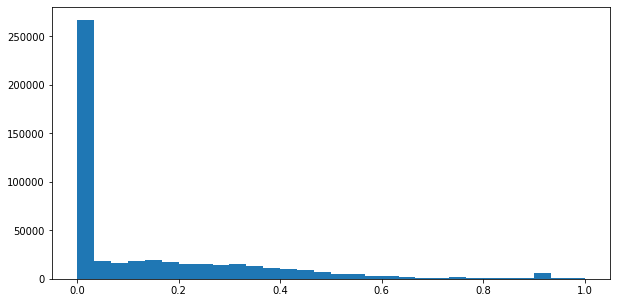

In [30]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['Dufrex'], 30, alpha = 1, density = False)
plt.show()

# 8. Lerch [[Paper](https://files.inria.fr/sachaproject/htdocs//lerch2013.pdf)]

In [31]:
dict_idf_frames = df_bag_of_frames.sum(axis = 0).apply(lambda x : 1 + math.log(df_bag_of_frames.shape[0] / x)).to_dict()

In [32]:
%%time
sim_lerch = df_distinct_stacks.apply(lambda x : lerch_df(x['listStackTrace'], df_distinct_stacks['listStackTrace'], rowIndex(x), dict_idf_frames), axis = 1)
df_measures['Lerch'] = pd.Series([element for l in sim_lerch for element in l])

CPU times: user 31.6 s, sys: 35.9 ms, total: 31.6 s
Wall time: 31.7 s


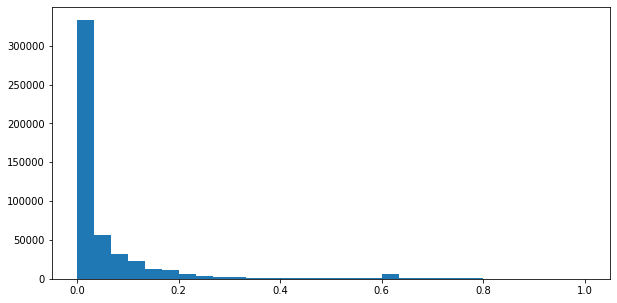

In [33]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['Lerch'], 30, alpha = 1, density = False)
plt.show()

# 9. Moroo [[Paper](http://ksiresearch.org/seke/seke17paper/seke17paper_135.pdf)]

In [34]:
%%time
sim_moroo = df_distinct_stacks.apply(lambda x : moroo_df(x['listStackTrace'], df_distinct_stacks['listStackTrace'], rowIndex(x), dict_idf_frames, alpha = 0.5), axis = 1)
df_measures['Moroo'] = pd.Series([element for l in sim_moroo for element in l])

CPU times: user 2min 56s, sys: 147 ms, total: 2min 56s
Wall time: 2min 57s


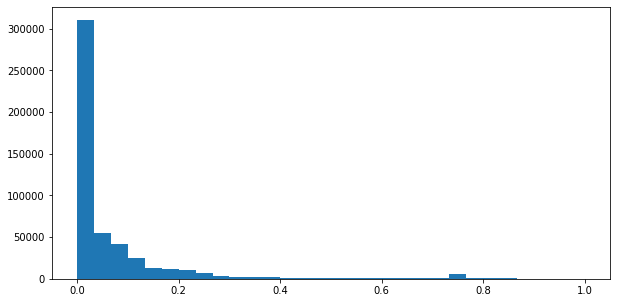

In [35]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['Moroo'], 30, alpha = 1, density = False)
plt.show()

# 10. TraceSim [[Paper](https://arxiv.org/pdf/2009.12590.pdf)]

In [38]:
%%time
alpha = 0.5
beta = 0.5
gamma = 0
sim_tracesim = df_distinct_stacks.apply(lambda x : traceSim_df(x['listStackTrace'], df_distinct_stacks['listStackTrace'], rowIndex(x), dict_idf_frames, alpha, beta, gamma), axis = 1)
df_measures['TraceSim'] = pd.Series([element for l in sim_tracesim for element in l])

CPU times: user 2min 33s, sys: 32.8 ms, total: 2min 33s
Wall time: 2min 34s


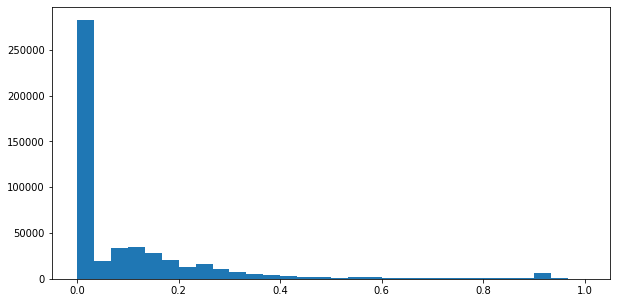

In [39]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['TraceSim'], 30, alpha = 1, density = False)
plt.show()

# Putting all together

## A. Distribution of similarity values

In [6]:
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

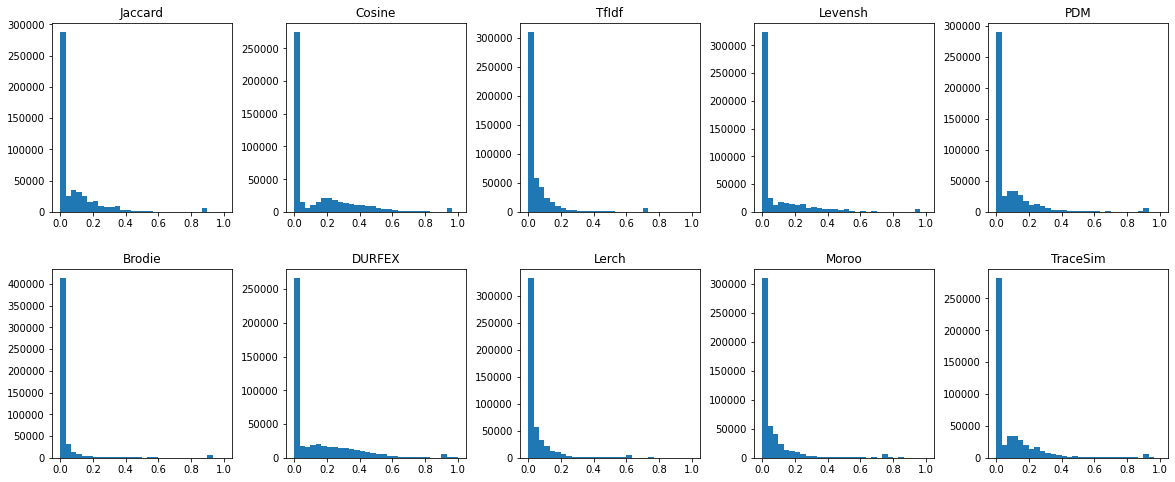

In [16]:
df_measures.hist(grid = False, figsize = (20,8), bins = 30, layout=(2, 5))
plt.show()

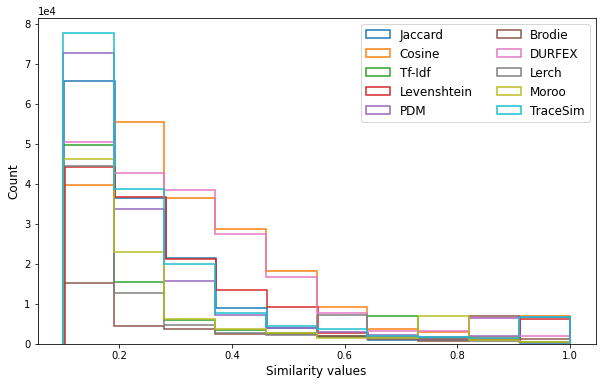

In [19]:
threshold = 0.1
linewidth = 1.5
bins = 10

df_measures[df_measures['Jaccard'] > threshold]['Jaccard'].hist(grid = False, histtype=u'step', label = 'Jaccard', linewidth = linewidth, bins = bins)
df_measures[df_measures['Cosine'] > threshold]['Cosine'].hist(grid = False, histtype=u'step', label = 'Cosine', linewidth = linewidth, bins = bins)
df_measures[df_measures['TfIdf'] > threshold]['TfIdf'].hist(grid = False, histtype=u'step', label = 'Tf-Idf', linewidth = linewidth, bins = bins)
df_measures[df_measures['Levensh'] > threshold]['Levensh'].hist(grid = False, histtype=u'step', label = 'Levenshtein', linewidth = linewidth, bins = bins)
df_measures[df_measures['PDM'] > threshold]['PDM'].hist(grid = False, histtype=u'step', label = 'PDM', linewidth = linewidth, bins = bins)
df_measures[df_measures['Brodie'] > threshold]['Brodie'].hist(grid = False, histtype=u'step', label = 'Brodie', linewidth = linewidth, bins = bins)
df_measures[df_measures['DURFEX'] > threshold]['DURFEX'].hist(grid = False, histtype=u'step', label = 'DURFEX', linewidth = linewidth, bins = bins)
df_measures[df_measures['Lerch'] > threshold]['Lerch'].hist(grid = False, histtype=u'step', label = 'Lerch', linewidth = linewidth, bins = bins)
df_measures[df_measures['Moroo'] > threshold]['Moroo'].hist(grid = False, histtype=u'step', label = 'Moroo', linewidth = linewidth, bins = bins)
df_measures[df_measures['TraceSim'] > threshold]['TraceSim'].hist(grid = False, histtype=u'step', label = 'TraceSim', linewidth = linewidth, bins = bins)
plt.rcParams["figure.figsize"] = [10, 6]
plt.legend(loc='upper right', fontsize = 12, ncol = 2)
plt.xlabel('Similarity values', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))
plt.savefig('../Images/distribution-similarities', bbox_inches='tight')

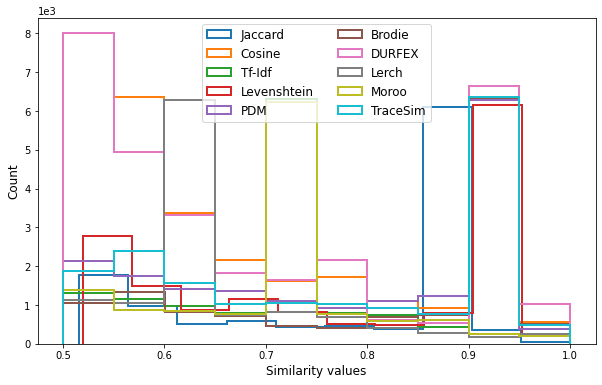

In [21]:
threshold = 0.5
linewidth = 2
bins = 10

df_measures[df_measures['Jaccard'] > threshold]['Jaccard'].hist(grid = False, histtype=u'step', label = 'Jaccard', linewidth = linewidth, bins = bins)
df_measures[df_measures['Cosine'] > threshold]['Cosine'].hist(grid = False, histtype=u'step', label = 'Cosine', linewidth = linewidth, bins = bins)
df_measures[df_measures['TfIdf'] > threshold]['TfIdf'].hist(grid = False, histtype=u'step', label = 'Tf-Idf', linewidth = linewidth, bins = bins)
df_measures[df_measures['Levensh'] > threshold]['Levensh'].hist(grid = False, histtype=u'step', label = 'Levenshtein', linewidth = linewidth, bins = bins)
df_measures[df_measures['PDM'] > threshold]['PDM'].hist(grid = False, histtype=u'step', label = 'PDM', linewidth = linewidth, bins = bins)
df_measures[df_measures['Brodie'] > threshold]['Brodie'].hist(grid = False, histtype=u'step', label = 'Brodie', linewidth = linewidth, bins = bins)
df_measures[df_measures['DURFEX'] > threshold]['DURFEX'].hist(grid = False, histtype=u'step', label = 'DURFEX', linewidth = linewidth, bins = bins)
df_measures[df_measures['Lerch'] > threshold]['Lerch'].hist(grid = False, histtype=u'step', label = 'Lerch', linewidth = linewidth, bins = bins)
df_measures[df_measures['Moroo'] > threshold]['Moroo'].hist(grid = False, histtype=u'step', label = 'Moroo', linewidth = linewidth, bins = bins)
df_measures[df_measures['TraceSim'] > threshold]['TraceSim'].hist(grid = False, histtype=u'step', label = 'TraceSim', linewidth = linewidth, bins = bins)
plt.rcParams["figure.figsize"] = [10, 6]
plt.legend(loc='upper center', fontsize = 12, ncol = 2)
plt.xlabel('Similarity values', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))
plt.savefig('../Images/distribution-similarities-geq-threshold', bbox_inches='tight')

## B. Kendall $\tau$ rank coefficient between similarity values

In [23]:
cross_kendall_matrix = np.zeros((len(df_measures.columns), len(df_measures.columns)), float)
np.fill_diagonal(cross_kendall_matrix, 1)
for i in range (len(df_measures.columns)-1) :
    for j in range(i + 1, len(df_measures.columns)) :
        measure1 = df_measures.columns[i]
        measure2 = df_measures.columns[j]
        tmp = df_measures[[measure1, measure2]]
        tmp = tmp[(tmp.T != 0).any()]
        A = tmp[measure1].values
        B = tmp[measure2].values
        tau, _ = stats.kendalltau(A, B)
        cross_kendall_matrix[i][j] = tau

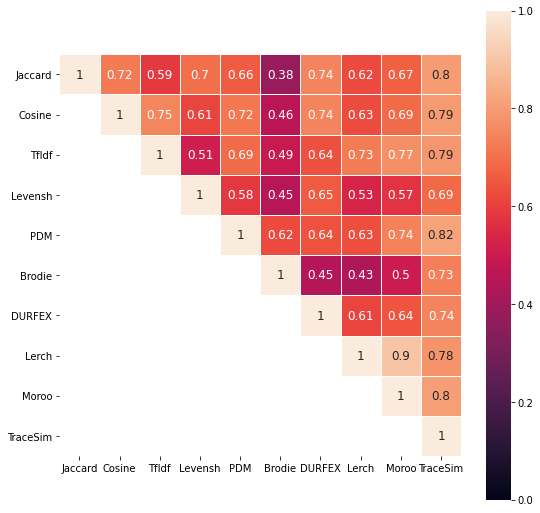

In [29]:
columns = list(df_measures.columns)
f, ax = plt.subplots(figsize=(9, 9))
mask = np.zeros_like(cross_kendall_matrix, subok = False)
mask[np.tril_indices_from(mask, k=-1)] = True
ax = sns.heatmap(cross_kendall_matrix, mask = mask, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.savefig('../Images/correlation-similarities', bbox_inches='tight')
plt.show()

In [9]:
df_measures.to_csv(data_repo + 'similarity-measures-pairs.csv')